In [53]:
# import Pkg; Pkg.add("LibSerialPort")
import Pkg; Pkg.add("TickTock")

   Resolving package versions...


   Installed TickTock ─ v1.2.0


    Updating `~/.julia/environments/v1.6/Project.toml`
  [9ff05d80] + TickTock v1.2.0
    Updating `~/.julia/environments/v1.6/Manifest.toml`
  [9ff05d80] + TickTock v1.2.0


Precompiling project...


  ✓ TickTock
  1 dependency successfully precompiled in 2 seconds (173 already precompiled)


In [54]:
using LibSerialPort
using TickTock
using Plots


list_ports()
ports = get_port_list()

/dev/cu.wlan-debug
	Description:	wlan-debug
	Transport type:	SP_TRANSPORT_NATIVE
/dev/cu.Bluetooth-Incoming-Port
	Description:	Bluetooth-Incoming-Port
	Transport type:	SP_TRANSPORT_NATIVE
/dev/cu.usbserial-56230387121
	Description:	USB Single Serial
	Transport type:	SP_TRANSPORT_NATIVE


3-element Vector{String}:
 "/dev/cu.wlan-debug"
 "/dev/cu.Bluetooth-Incoming-Port"
 "/dev/cu.usbserial-56230387121"

In [12]:
ports

3-element Vector{String}:
 "/dev/cu.wlan-debug"
 "/dev/cu.Bluetooth-Incoming-Port"
 "/dev/cu.usbserial-56230387121"

In [196]:
using LibSerialPort

sp = LibSerialPort.open("/dev/cu.usbserial-56230387121", 115200)
set_flow_control(sp)
sp_flush(sp, SP_BUF_BOTH)
println(readline(sp))
write(sp, "<0, 0>") # first is elbow, second is linear rail

close(sp)

-2.411,-0.219,-0.658,0.000,-1.043,0.000,0.000,0.000,


In [226]:
# set the acceleration to 100 for 1 second with dt of 1ms

dt = 0.005
tf = 0.2
t_vec = 0:dt:tf
N = length(t_vec)
linearPositions = zeros(N)
elbowPositions = zeros(N)
linearVelocities = zeros(N)
elbowVelocities = zeros(N)
shoulderPositions = zeros(N)
shoulderVelocities = zeros(N)

println(N)

sp = LibSerialPort.open("/dev/cu.usbserial-56230387121", 115200)
set_flow_control(sp)
sp_flush(sp, SP_BUF_BOTH)

tick()
for i in 1:N
    encoders = readline(sp)
    encodersSplit = split(encoders, ",")

    linearPositions[i] = parse(Float64, encodersSplit[1])
    linearVelocities[i] = parse(Float64, encodersSplit[2])
    shoulderPositions[i] = parse(Float64, encodersSplit[3])
    shoulderVelocities[i] = parse(Float64, encodersSplit[4])
    elbowPositions[i] = parse(Float64, encodersSplit[5])
    elbowVelocities[i] = parse(Float64, encodersSplit[6])

    if (i < N/2)
        write(sp, "<0, 4000>") # first is elbow, second is linear rail
    else
        write(sp, "<0, 0>") # first is elbow, second is linear rail
    end

    sleep(dt)
end
tock()

write(sp, "<0, 0>") # first is elbow, second is linear rail
close(sp)


41


┌ Info:  started timer at: 2023-05-03T22:13:33.204
└ @ TickTock /Users/saraltayal/.julia/packages/TickTock/fGILW/src/TickTock.jl:54


┌ Info:          0.318918166s: 318 milliseconds
└ @ TickTock /Users/saraltayal/.julia/packages/TickTock/fGILW/src/TickTock.jl:62


In [227]:
ENCODER_LINEAR_ANGULAR_RATIO_M = 0.00602;
ENCODER_LINEAR_ANGULAR_RATIO_CM = 0.602;
ENCODER_ELBOW_ANGULAR_RATIO= 0.2;
ENCODER_SHOULDER_ANGULAR_RATIO = 1.0;

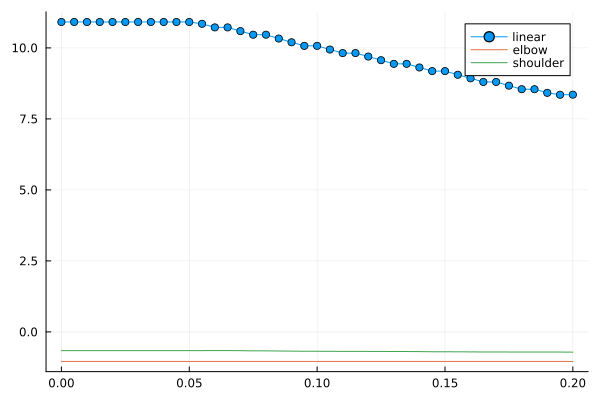

In [228]:
# plot the various positions over time
plot(t_vec, linearPositions * ENCODER_LINEAR_ANGULAR_RATIO_CM, label="linear", marker=:dot)
plot!(t_vec, elbowPositions, label="elbow")
plot!(t_vec, shoulderPositions, label="shoulder")

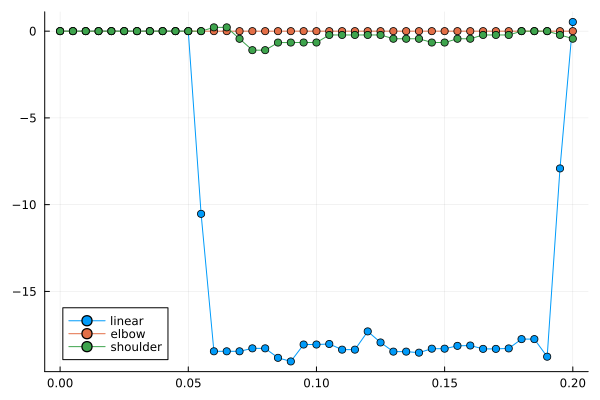

In [229]:
# plot the various velocities over time, each point should be a dot
plot(t_vec, linearVelocities * ENCODER_LINEAR_ANGULAR_RATIO_CM, label="linear", marker=:dot)
plot!(t_vec, elbowVelocities, label="elbow", marker=:dot)
plot!(t_vec, shoulderVelocities, label="shoulder", marker=:dot)

In [232]:
# print the start and final linear position
println("Start: ", linearPositions[1])
println("Final: ", linearPositions[end]) 

angularDistance = linearPositions[end] - linearPositions[1]
angularDistance = angularDistance * ENCODER_LINEAR_ANGULAR_RATIO_CM

println("Angular distance: ", angularDistance)

println("Ratio:", physicalDistance/angularDistance);

Start: 18.126
Final: 13.876
Angular distance: -2.558500000000001
Ratio:-1.426617158491303


Problems: 
* Inconsistent sleep time